In [1]:
import json
import pandas as pd
from typing import Dict, Tuple, List
import os, sys
from model.indexer import Indexer
from model.indexer import load_amr_config

amr, slot, task, precedence = load_amr_config("data/amr3_slots4_task4.json")
print(amr)
print(slot)
print(task)
print(precedence)

from model.indexer import assign_ent_to_indexer
indexer = Indexer()
indexer_, x, y, w = assign_ent_to_indexer(indexer, amr, slot, task)
def indexer_to_dataframe(indexer):
    data = []
    for idx, key in enumerate(indexer._from_idx):
        data.append({"index": idx, "variable": key})
    df = pd.DataFrame(data)
    return df
df = indexer_to_dataframe(indexer)
print(df)

['R1', 'R2', 'R3']
[0, 1, 2, 3]
[{'name': 'T1', 'p': 1}, {'name': 'T2', 'p': 2}, {'name': 'T3', 'p': 3}, {'name': 'T4', 'p': 2}]
[['T1', 'T3'], ['T2', 'T3']]
    index        variable
0       0     (x, T1, R1)
1       1     (x, T1, R2)
2       2     (x, T1, R3)
3       3      (y, T1, 0)
4       4      (y, T1, 1)
..    ...             ...
71     71  (w, T4, R2, 3)
72     72  (w, T4, R3, 0)
73     73  (w, T4, R3, 1)
74     74  (w, T4, R3, 2)
75     75  (w, T4, R3, 3)

[76 rows x 2 columns]


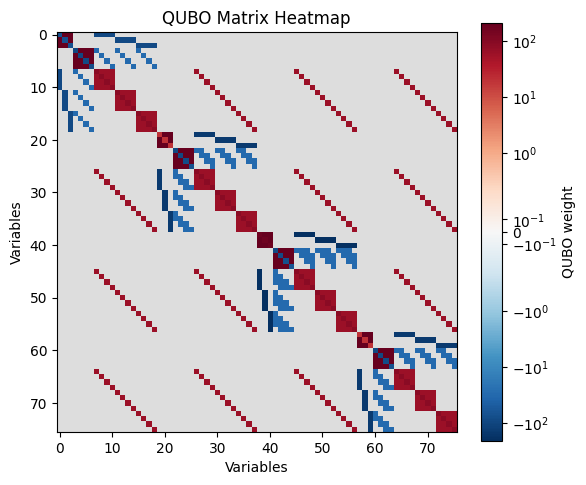

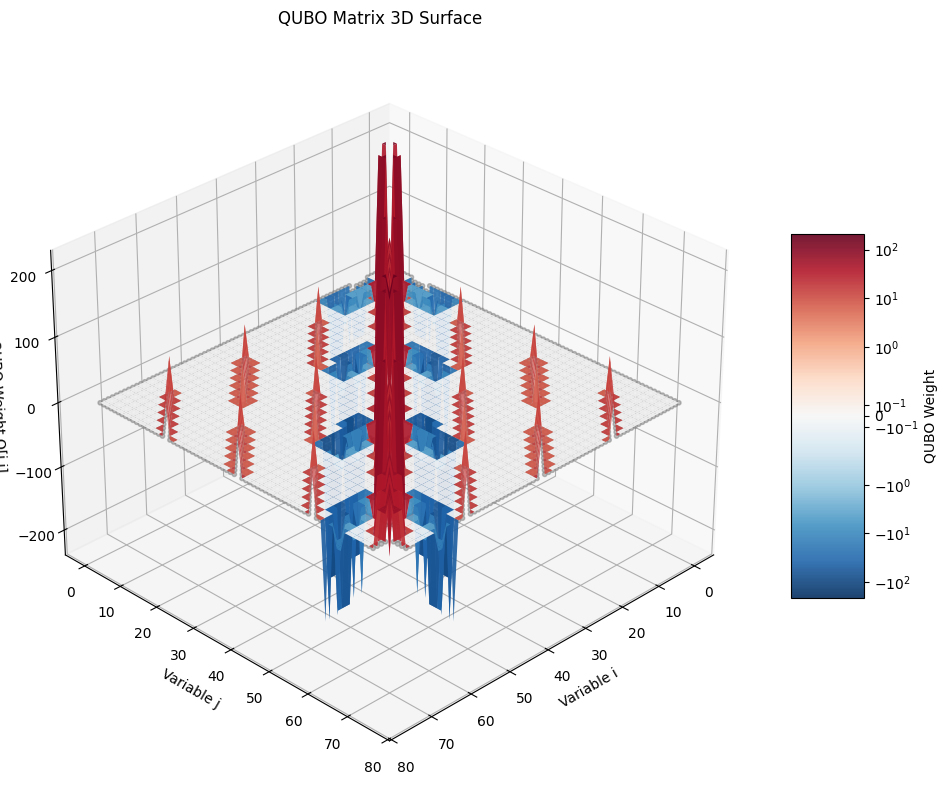

(<Figure size 1000x800 with 2 Axes>,
 <Axes3D: title={'center': 'QUBO Matrix 3D Surface'}, xlabel='Variable i', ylabel='Variable j', zlabel='QUBO Weight Q[i,j]'>)

In [2]:
from model.qubo_builder import QuboBuilder
qb = QuboBuilder(indexer)
from model.objectives.makespan import add_makespan_objective
from model.objectives.balance import add_workload_balance_objective
w_makespan = 1.0
w_balance = 0.5
add_makespan_objective(qb, task, slot, y, w_makespan)
#add_workload_balance_objective(qb, task, amr, x, w_balance)
df = qb.to_dataframe(use_labels=True)
#print(df)

from model.constraints import c1
c1.add_startslot_exactly_one_constraints(qb, task, slot, y, lam_c1=100) 
from model.constraints import c2
c2.add_assignment_exactly_one_constraints(qb, task, amr, x, lam_c2=100)
from model.constraints import c3_
c3_.add_c3_capacity_no_overlap(qb, task, amr, slot, x, y, w, lam_c3_and=30, lam_c3_cap=30)
import old.plot_qb_heatmap as plot_qb_heatmap
import importlib
importlib.reload(plot_qb_heatmap)
df = qb.to_dataframe(use_labels=True)
plot_qb_heatmap.plot_qubo_heatmap(df, labels=df.columns.tolist(),linthresh=0.5, tiny_mark=0.1, vmax_pct=99.5)
plot_qb_heatmap.plot_qubo_3d_surface(df)

In [3]:
import numpy as np
df = qb.to_dataframe()
H_obj = df.filter(like='objective')  # falls du sie getaggt hast
print("QUBO absolute values:", np.percentile(np.abs(df.values), [5,50,95]))

QUBO absolute values: [ 0.  0. 60.]


In [10]:
import dimod, neal
import time
Q = dict(qb.Q) 
Q_upper = {(i, j): w for (i, j), w in Q.items() if i <= j}
bqm = dimod.BinaryQuadraticModel.from_qubo(Q_upper)
sampler = neal.SimulatedAnnealingSampler()
start = time.time()
sampleset = sampler.sample(bqm, num_reads=5000, sweeps=20000, beta_range=(0.1, 10.0), seed=123)
end = time.time()
algo_zeit = end - start
print("ZEIT",algo_zeit)
print(sampleset)
asym = [((i,j), w - Q.get((j,i),0.0)) for (i,j), w in Q.items() if i>j and abs(w - Q.get((j,i),0.0))>1e-9]
print("Asymmetrien:", len(asym))
E_neal = sampleset.lowest().first.energy
print(E_neal)

ZEIT 2.414978504180908
      0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 ... 75 energy num_oc.
1147  0  1  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0 ...  0 -777.0       1
2762  0  1  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0 ...  0 -777.0       1
3325  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  1  0 ...  0 -777.0       1
432   1  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0 ...  0 -772.0       1
1863  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  1  0 ...  0 -772.0       1
3330  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  1  0 ...  0 -772.0       1
312   0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  1  0 ...  0 -770.0       1
527   0  1  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0 ...  0 -770.0       1
3420  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  1  0 ...  0 -770.0       1
71    0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0 ...  0 -769.0       1
4451  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0 ...  0 -769.0       1
1249  0  1  0  0  1  0  0  0  0  0  0  0 

In [4]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import CplexOptimizer
import time
Q = dict(qb.Q)
Q_upper = {(i, j): w for (i, j), w in Q.items() if i <= j}
n = max(max(i, j) for (i, j) in Q.keys()) + 1
qp = QuadraticProgram()
qp.binary_var_list(n)
linear = {}
quadratic = {}
for (i, j), weight in Q.items():
    if i == j:
        linear[i] = linear.get(i, 0.0) + weight
    else:
        a, b = (i, j) if i < j else (j, i)
        quadratic[(a, b)] = quadratic.get((a, b), 0.0) + weight
qp.minimize(linear=linear, quadratic=quadratic)
optimizer = CplexOptimizer()
start = time.time()
result = optimizer.solve(qp)
end = time.time()
algo_zeit = end - start
print("ZEIT",algo_zeit)
print(result)            
print("Objektwert:", result.fval)
print("Lösung x:", result.x)

# Wenn du die Lösung als Dict möchtest (Index -> 0/1):
solution = {i: int(round(v)) for i, v in enumerate(result.x)}
print("Lösung (Dict):", solution)

ZEIT 1.330871820449829
fval=-777.0, x0=1.0, x1=0.0, x2=0.0, x3=1.0, x4=0.0, x5=0.0, x6=0.0, x7=1.0, x8=0.0, x9=0.0, x10=0.0, x11=0.0, x12=0.0, x13=0.0, x14=0.0, x15=0.0, x16=0.0, x17=0.0, x18=0.0, x19=0.0, x20=1.0, x21=0.0, x22=1.0, x23=0.0, x24=0.0, x25=0.0, x26=0.0, x27=0.0, x28=0.0, x29=0.0, x30=1.0, x31=1.0, x32=0.0, x33=0.0, x34=0.0, x35=0.0, x36=0.0, x37=0.0, x38=0.0, x39=0.0, x40=1.0, x41=1.0, x42=0.0, x43=0.0, x44=0.0, x45=0.0, x46=0.0, x47=0.0, x48=0.0, x49=0.0, x50=0.0, x51=0.0, x52=0.0, x53=1.0, x54=0.9999999999999998, x55=1.0, x56=0.0, x57=1.0, x58=0.0, x59=0.0, x60=0.0, x61=1.0, x62=0.0, x63=0.0, x64=0.0, x65=1.0, x66=1.0, x67=0.0, x68=0.0, x69=0.0, x70=0.0, x71=0.0, x72=0.0, x73=0.0, x74=0.0, x75=0.0, status=SUCCESS
Objektwert: -777.0
Lösung x: [1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0.

In [6]:
from old.decode_best_solution import invert_map, decode_sample

inv_x = invert_map(x)        # idx -> (tname, rname)
inv_y = invert_map(y)        # idx -> (tname, z)
inv_w = invert_map(w) 

# this one is for cplex optimizer
sample = {i: int(round(v)) for i, v in enumerate(result.x)}

# this one is for dimod sampler
#sample = {int(k): int(v) for k, v in sampleset.first.sample.items()}
chosen_x, chosen_y, chosen_w = decode_sample(sample, inv_x, inv_y, inv_w)
print("X=1:", chosen_x)
print("Y=1:", chosen_y)
print("W=1:", chosen_w)

X=1: [('x', 'T1', 'R1'), ('x', 'T2', 'R2'), ('x', 'T3', 'R3'), ('x', 'T4', 'R1')]
Y=1: [('y', 'T1', 0), ('y', 'T2', 0), ('y', 'T3', 0), ('y', 'T4', 1)]
W=1: [('w', 'T1', 'R1', 0), ('w', 'T2', 'R2', 0), ('w', 'T2', 'R2', 1), ('w', 'T3', 'R3', 0), ('w', 'T3', 'R3', 1), ('w', 'T3', 'R3', 2), ('w', 'T4', 'R1', 1), ('w', 'T4', 'R1', 2)]


C:\Users\Prüfer\AppData\Local\Temp\ipykernel_36696\3292997903.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max(20, len(labels)))  # diskrete Palette


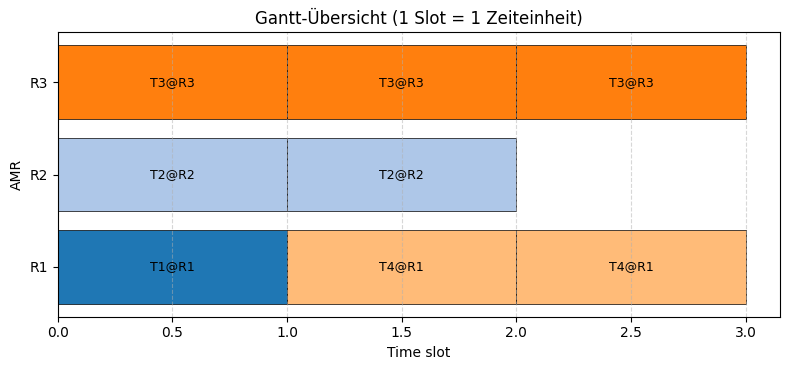

Zuordnung x (Task → Roboter):
  - T1 → R1
  - T2 → R2
  - T3 → R3
  - T4 → R1
Startslots y (Task → Startslot):
  - T1 beginnt bei Slot 0
  - T2 beginnt bei Slot 0
  - T3 beginnt bei Slot 0
  - T4 beginnt bei Slot 1
Belegte Slots w (Task, Roboter, Slot):
  - R1 bei Slot 0: T1
  - R1 bei Slot 1: T4
  - R1 bei Slot 2: T4
  - R2 bei Slot 0: T2
  - R2 bei Slot 1: T2
  - R3 bei Slot 0: T3
  - R3 bei Slot 1: T3
  - R3 bei Slot 2: T3
Keine Konflikte erkannt.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Derive robots and tasks
robots = sorted({r for _, t, r in chosen_x} | {r for _, t, r, z in chosen_w})
tasks = sorted({t for _, t, r in chosen_x} | {t for _, t, z in chosen_y} | {t for _, t, r, z in chosen_w})
slots = sorted({z for _, t, r, z in chosen_w} | {z for _, t, z in chosen_y})

# Build schedule table: rows = time slots, columns = robots, value = list of tasks running
schedule = {r: {z: [] for z in slots} for r in robots}
for _, t, r, z in chosen_w:
    schedule[r][z].append(t)

df = pd.DataFrame({r: [", ".join(schedule[r][z]) if schedule[r][z] else "" for z in slots] for r in robots},
                  index=slots)
df.index.name = "Time slot"

# Detect conflicts (more than one task on the same robot & time slot)
conflicts = []
for r in robots:
    for z in slots:
        if len(schedule[r][z]) > 1:
            conflicts.append((r, z, schedule[r][z]))

# Display the schedule table to the user
#from caas_jupyter_tools import display_dataframe_to_user
#display_dataframe_to_user("Theoretischer Arbeitsplan (Slots × Roboter)", df)

# Build a simple Gantt-like chart per robot (horizontal bars for each task segment)
# We'll draw each task segment as a single-slot bar (duration = 1) wherever w=1.
# If tasks span consecutive slots, they will appear as adjacent bars.
fig, ax = plt.subplots(figsize=(8, 2 + 0.6*len(robots)))

# Map robots to lanes
robot_to_lane = {r: i for i, r in enumerate(robots)}

# Collect segments: (lane, start, duration, label)
segments = []
for _, t, r, z in chosen_w:
    lane = robot_to_lane[r]
    segments.append((lane, z, 1, f"{t}@{r}"))

# -------- NEU: konsistente Farben pro (Task, Roboter) --------
# Alle Labels (t@r), stabil sortiert -> Farbindex
labels = sorted({lbl for _, _, _, lbl in segments})
cmap = plt.cm.get_cmap('tab20', max(20, len(labels)))  # diskrete Palette
label_to_color = {lbl: cmap(i % cmap.N) for i, lbl in enumerate(labels)}

# Draw bars mit konsistenten Farben
for lane, start, dur, label in segments:
    ax.barh(lane, dur, left=start, color=label_to_color[label], edgecolor='black', linewidth=0.5)
    ax.text(start + dur/2, lane, label, va='center', ha='center', fontsize=9)




ax.set_yticks(list(robot_to_lane.values()), list(robot_to_lane.keys()))
ax.set_xlabel("Time slot")
ax.set_ylabel("AMR")
ax.set_title("Gantt-Übersicht (1 Slot = 1 Zeiteinheit)")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Prepare a short textual summary of assignments and conflicts
summary_lines = []
summary_lines.append("Zuordnung x (Task → Roboter):")
for _, t, r in chosen_x:
    summary_lines.append(f"  - {t} → {r}")
summary_lines.append("Startslots y (Task → Startslot):")
for _, t, z in chosen_y:
    summary_lines.append(f"  - {t} beginnt bei Slot {z}")
summary_lines.append("Belegte Slots w (Task, Roboter, Slot):")
for _, t, r, z in sorted(chosen_w, key=lambda e: (e[2], e[3], e[1])):
    summary_lines.append(f"  - {r} bei Slot {z}: {t}")

if conflicts:
    summary_lines.append("⚠️ Konflikte erkannt (mehr als ein Task auf demselben Roboter im selben Slot):")
    for r, z, ts in conflicts:
        summary_lines.append(f"  - {r} Slot {z}: {', '.join(ts)}")
else:
    summary_lines.append("Keine Konflikte erkannt.")

print("\n".join(summary_lines))